In [1]:
import numpy as np
import research
import view
import lib.gradients as grad
import lib.data as data
import matplotlib.pyplot as plt
import decompozition
import lib.mesurements
%matplotlib inline

In [34]:
def poisson_noise(image, photons):
    """
    Add Poisson (Shot) noise to an image for the given 
    number of photons corresponding to maximum intensity.
    
    :param image: The original image
    :param photons: The number of photons corresponding to maximum intensity
    :return: returns the array of the original type with added Poisson noise
    """
    # saving original type
    original_type = image.dtype
    # converting image to float array
    noised_image = image.astype(np.float64)
    # getting number of layers
    layers_number = image.shape[-1]
    
    # adding noise for each level
    #for i in range(0, layers_number):
        # scaling image intensity to [0, 1]
        # and then to the given number of photons
    scale_factor = photons / noised_image[:,:].max()
    noised_image[:,:] = noised_image[:,:] * scale_factor
    # adding Poisson noise 
    noised_image[:,:] = np.random.poisson(noised_image[:,:])
    # scaling the intensity back to the original one
    noised_image[:,:] = noised_image[:,:] / scale_factor
    
    # back to the original array type
    noised_image = noised_image.astype(original_type)
    
    return noised_image

In [35]:
def poisson_noised(image, photons):
    step = image.min()
    if (step < 0):
        image -= step
    noised_image = poisson_noise(image, photons)
    if (step < 0):
        noised_image += step
    return noised_image

In [36]:
def my_exp(x,y,w1,w2):
    if (w1 == 0):
        return np.exp( w2*1j*y)
    return np.exp(w1*1j*x + w2*1j*y)

cпектр комлексной экспоненты с индексом i,j

#to do
исправить баг, с индексами i,j

функция compare вычисляет $e^{(1j*i*x, 1j*j*y)}$ на сеткe 2**M x 2**M.
затем находя градиенты , вычисляет значение функции.
noised определяет будет ли зашумлена функция.
возвращает отношение спектров исходного и восстановленного сигналов.
т.к. спектр комлескной экспоненты exp(1j*i*x, 1j*j*y) дельта функция, всё значение сосредоточено в 
окрестности точки i,j.
2 варианта , что возвращает функция :

1.отношение cпектров на [i,j] позиции


2.отнощение максимумов спекторов

ниже 2 варианта.

In [37]:
def compare(i,j,M, noised = False, photons = 1):
    x,y = data.get_plane(-np.pi, np.pi,-np.pi,np.pi,M)
    im = my_exp(x,y,i,j)
    grad_X, grad_Y = grad.fried_model_gradient(im)
    X_H, Y_H = grad.Hudgin_gradien_model(im)
    if (noised):
        #как зашумлять комплексные числа?
        grad_X = poisson_noised(grad_X.real, photons) + 1j*poisson_noised(grad_X.imag, photons)
        grad_Y = poisson_noised(grad_Y.real, photons) + 1j*poisson_noised(grad_Y.imag, photons)
        X_H = poisson_noised(X_H.real, photons) + 1j*poisson_noised(X_H.imag, photons)
        Y_H = poisson_noised(Y_H.real, photons) + 1j*poisson_noised(Y_H.imag, photons)
    LH, HL, HH = decompozition.analyze(grad_X, grad_Y, X_H, Y_H)
    res = decompozition.syntesis({0:np.array([[np.mean(im)*2**M]])}, LH, HL, HH,M)
    #print(np.abs(np.fft.fft2(im)[j,i]), np.abs(np.fft.fft2(res[M])[j,i]))
    #print(np.max(np.abs(np.fft.fft2(im))), np.max(np.abs(np.fft.fft2(res[M]))))
    return np.abs(np.fft.fft2(im)[j,i])/np.abs(np.fft.fft2(res[M])[j,i])
    #return np.max(np.abs(np.fft.fft2(im))) / np.max(np.abs(np.fft.fft2(res[M])))

In [38]:
def calc_z (M, noised = False, photons = 1):
    size = 2**M
    z = np.zeros(size**2).reshape(size,size)
    for i in range (size):
        for j in range(size):
            z[i,j] = compare(i,j,M, noised)
    return z

In [39]:
def draw_plot(z):
    size = z.shape[0]
    x,y = np.meshgrid(range(0,size),range(0,size))
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(30,30))
    ax = fig.gca(projection='3d')
    ax.plot_wireframe(x, y, z)
    ax.set_zlim(0, 2)
    ax.set_xlim(0,size)
    ax.set_ylim(0,size)
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    majorLocator = MultipleLocator(2)
    majorFormatter = FormatStrFormatter('%d')
    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.yaxis.set_major_locator(majorLocator)
    ax.yaxis.set_major_formatter(majorFormatter)

In [47]:
z = calc_z(6, True,10000)
#try catch везде

/home/satbek/python/anacondas/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/home/satbek/python/anacondas/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply
/home/satbek/python/anacondas/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
/home/satbek/python/anacondas/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


KeyboardInterrupt: 

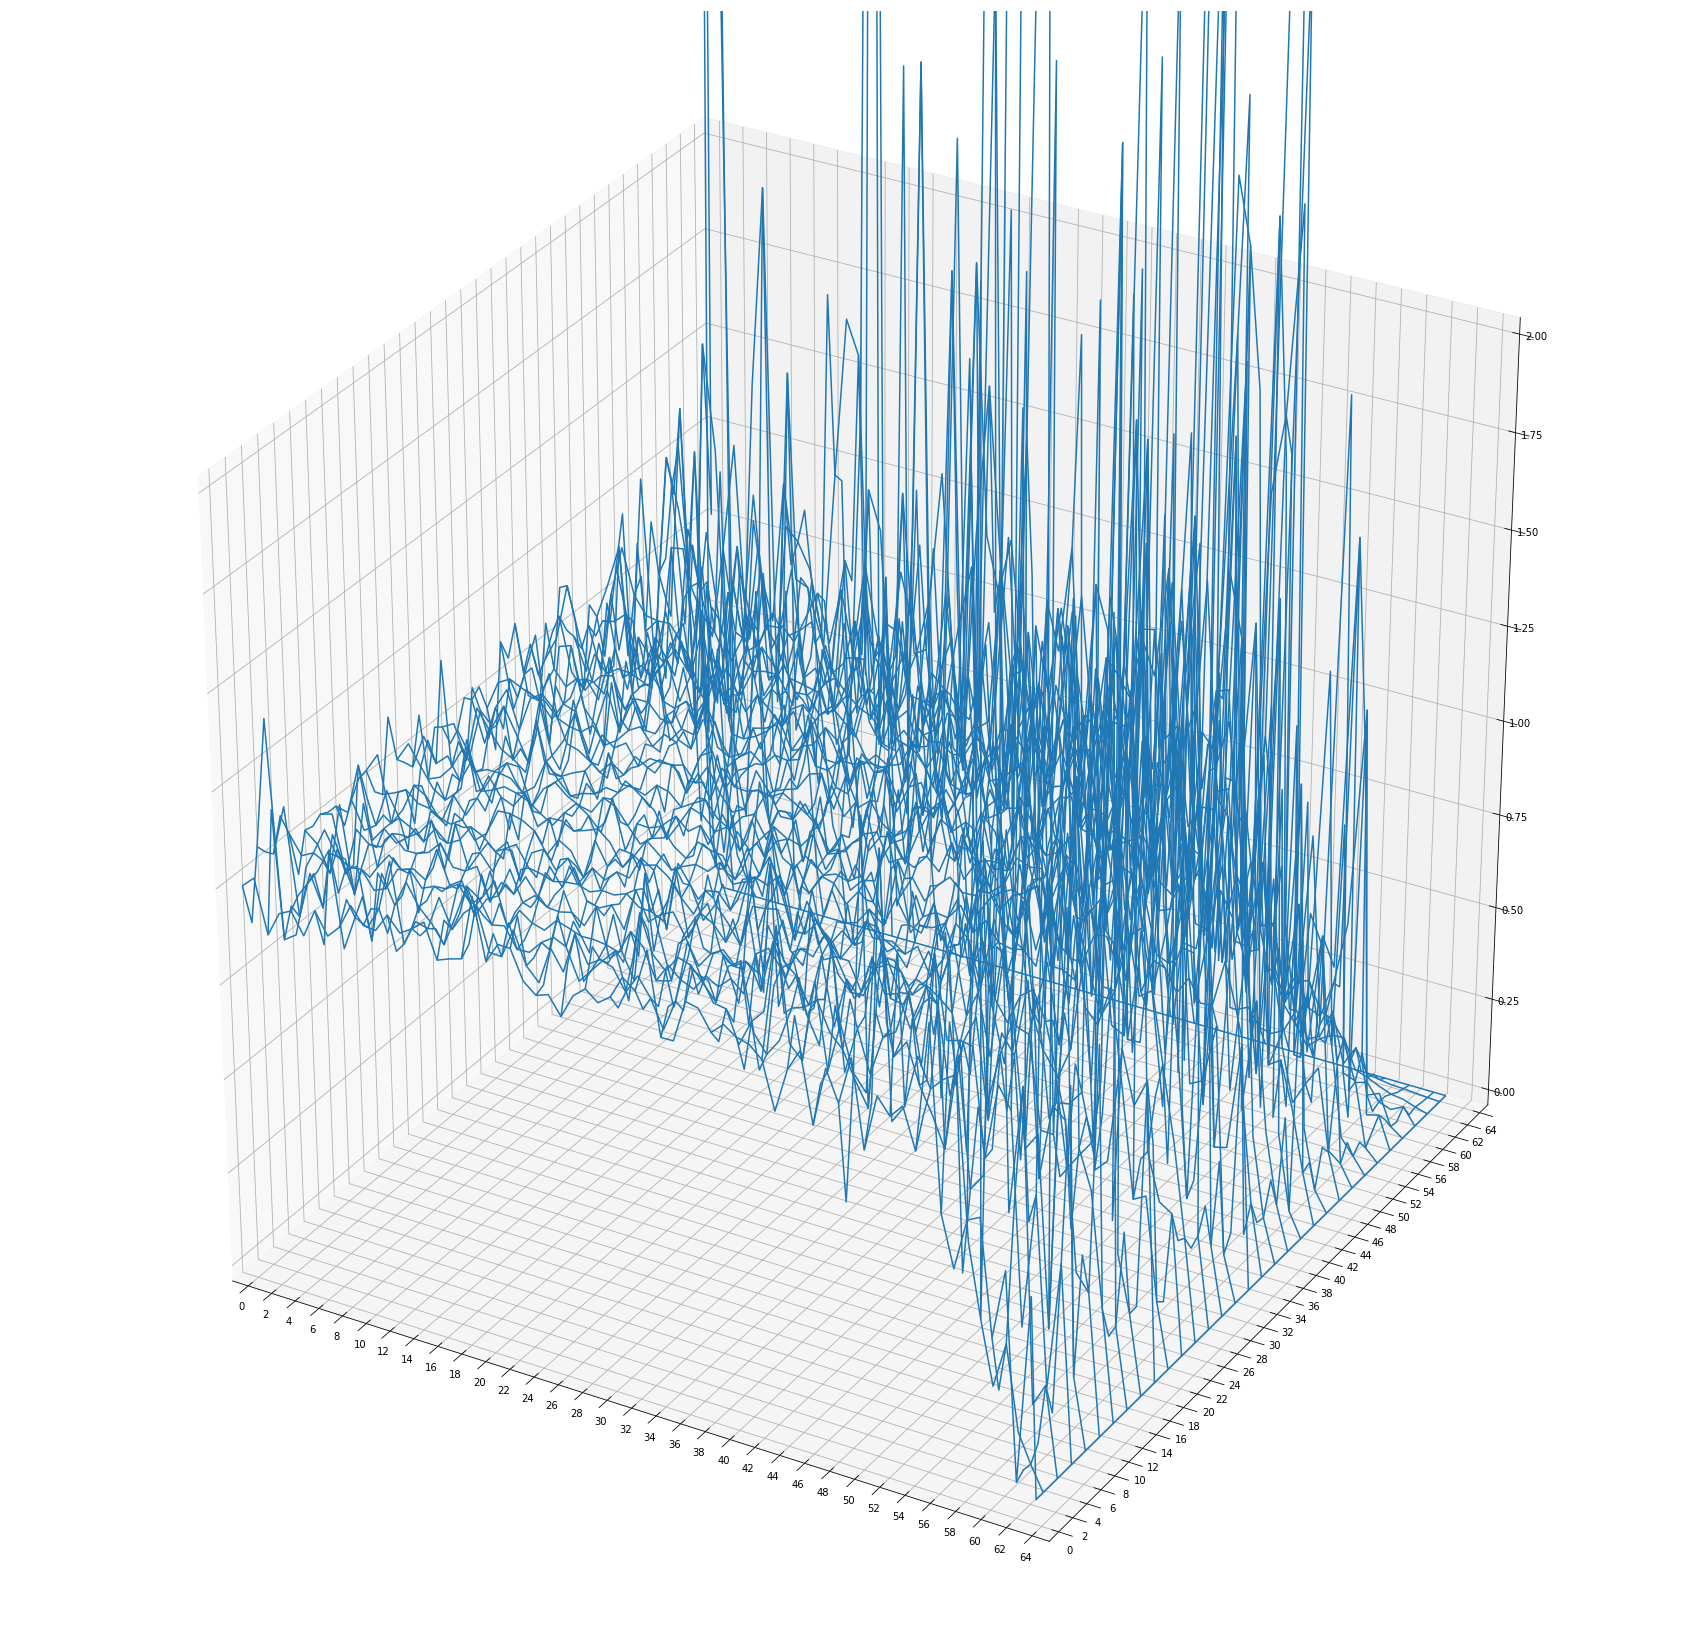

In [46]:
draw_plot(z)